# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

In [2]:
#pip install openpyxl

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [4]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [7]:
time0 = time.time()

with open('../input/lc-800k-sample/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status',
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc',                 
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint']

df = df[features_tokeep]

#df.drop(columns = ['pymnt_plan', 'fico_range_low', 'recoveries', 'collection_recovery_fee', 'last_fico_range_low', 'policy_code',
#                  'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
#                  'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
#                  'collections_12_mths_ex_med', 'acc_now_delinq'],inplace=True)
# fico bucket is always 5 points increment, so I drop lower bound as redundant info
# I drop most of the features above, since they seem to be collected after origination.
display(df.head())
#df.drop(columns = ['mths_since_last_record', 'mths_since_last_delinq',
#                  'mths_since_last_major_derog'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(100000)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,il_util,tot_cur_bal,revol_bal,revol_util,max_bal_bc,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint
2,Fully Paid,2400.0,2400.0,2400.0,36.0,15.96,84.330002,Dec-2011,small_business,real estate business,f,Individual,C,C5,739.0,NaN,10+ years,RENT,12252.0,606xx,IL,8.72,Not Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov-2001,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,NaN,NaN,2956.0,98.5,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
8,Charged Off,5600.0,5600.0,5600.0,60.0,21.28,152.389999,Dec-2011,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,NaN,4 years,OWN,40000.0,958xx,CA,5.55,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr-2004,2.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,NaN,NaN,5210.0,32.6,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
11,Fully Paid,12000.0,12000.0,12000.0,36.0,12.69,402.540009,Dec-2011,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10+ years,OWN,75000.0,913xx,CA,10.78,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct-1989,0.0,NaN,NaN,12.0,NaN,NaN,34.0,NaN,NaN,NaN,23336.0,67.1,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
13,Fully Paid,3000.0,3000.0,3000.0,36.0,9.91,96.680000,Dec-2011,credit_card,citicard fund,f,Individual,B,B1,709.0,Target,3 years,RENT,15000.0,606xx,IL,12.56,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul-2003,2.0,NaN,NaN,11.0,NaN,NaN,11.0,NaN,NaN,NaN,7323.0,43.1,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
16,Fully Paid,10000.0,10000.0,10000.0,36.0,15.27,347.980011,Dec-2011,home_improvement,Home,f,Individual,C,C4,674.0,Chin's Restaurant,4 years,RENT,42000.0,921xx,CA,18.60,Not Verified,NaN,61.0,NaN,NaN,NaN,NaN,NaN,Oct-1998,2.0,NaN,NaN,14.0,NaN,NaN,28.0,NaN,NaN,NaN,24043.0,70.2,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


(100000, 52)

4.80186653137207

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,il_util,tot_cur_bal,revol_bal,revol_util,max_bal_bc,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint
46869,Fully Paid,6500.0,6500.0,6500.0,36.0,11.47,214.259995,May-2016,debt_consolidation,Debt consolidation,w,Individual,B,B5,679.0,Transaction Coordinator,< 1 year,MORTGAGE,40000.0,891xx,NV,7.050000,Source Verified,7.0,NaN,NaN,38.0,NaN,NaN,4.0,Feb-1999,0.0,0.0,1.0,14.0,9.0,1.0,22.0,1161.0,84.0,13935.0,7276.0,44.1,3535.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN
93889,Current,34000.0,34000.0,34000.0,36.0,8.19,1068.420044,Jan-2020,credit_card,Credit card refinancing,w,Individual,A,A4,674.0,Event Manager,10+ years,OWN,60000.0,327xx,FL,16.940001,Source Verified,5.0,63.0,63.0,NaN,NaN,63.0,1.0,May-1996,1.0,0.0,1.0,16.0,2.0,2.0,45.0,5739.0,NaN,91825.0,31044.0,53.4,7139.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
98243,Fully Paid,13000.0,13000.0,13000.0,60.0,22.39,361.940002,Jul-2016,debt_consolidation,NaN,f,Individual,E,E1,669.0,confirmation specialist,3 years,RENT,42000.0,212xx,MD,14.740000,Verified,5.0,32.0,32.0,NaN,NaN,NaN,2.0,May-2004,0.0,0.0,0.0,6.0,4.0,0.0,11.0,3607.0,80.0,21640.0,2481.0,32.2,1022.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
36497,Late (16-30 days),30000.0,30000.0,30000.0,36.0,14.47,1032.199951,Sep-2018,debt_consolidation,Debt consolidation,w,Individual,C,C2,709.0,Lead technician,7 years,RENT,70000.0,945xx,CA,3.170000,Source Verified,1.0,37.0,NaN,NaN,NaN,37.0,3.0,Oct-2006,0.0,1.0,1.0,8.0,7.0,0.0,36.0,1470.0,NaN,11763.0,11763.0,26.4,10576.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
10612,Current,10000.0,10000.0,10000.0,36.0,11.99,332.100006,Jun-2017,debt_consolidation,Debt consolidation,f,Individual,B,B5,719.0,detective,10+ years,MORTGAGE,110000.0,106xx,NH,14.990000,Source Verified,5.0,48.0,48.0,NaN,48.0,48.0,2.0,Jun-2003,1.0,0.0,1.0,8.0,5.0,1.0,28.0,13409.0,80.0,107275.0,7937.0,33.9,723.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [140]:
list(df.columns)

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'mort_acc',
 'pub_rec_bankruptcies']

In [137]:
### feature decription:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])


,colname,desc
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
5,annual_inc_joint,The combined self-reported annual income provi...
6,application_type,Indicates whether the loan is an individual ap...
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/...


73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [113]:
# clean time features

df.issue_d = df.issue_d.astype('O')
df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92461480,12000,12000,12000.0,36,10.49,389.980011,B,B2,Captain,4 years,MORTGAGE,100000.0,Not Verified,2016-11-01,Charged Off,car,Car financing,330xx,FL,6.200000,0.0,2006-02-01,669,0.0,4.0,0.0,3019,24.0,8.0,w,Individual,NaN,NaN,NaN,0.0,0.0,2016,11,2016,10.749023,0.0
159859336,11600,11600,11600.0,60,11.02,252.330002,B,B2,NaN,NaN,RENT,26000.0,Not Verified,2019-10-01,Current,credit_card,Credit card refinancing,986xx,WA,27.980000,0.0,2012-06-01,724,0.0,6.0,0.0,12091,47.2,7.0,w,Individual,NaN,NaN,NaN,0.0,0.0,2019,10,2019,7.332115,0.0
167377888,8100,8100,8100.0,36,14.30,278.029999,C,C1,Project Manager,3 years,RENT,127680.0,Source Verified,2020-02-01,Current,credit_card,Credit card refinancing,950xx,CA,21.299999,0.0,2008-09-01,699,1.0,18.0,0.0,22166,34.2,21.0,w,Individual,NaN,NaN,NaN,0.0,0.0,2020,2,2020,11.417072,0.0
131936255,14400,14400,14400.0,36,6.07,438.540009,A,A2,Controller,5 years,RENT,130000.0,Not Verified,2018-04-01,Current,credit_card,Credit card refinancing,606xx,IL,14.310000,0.0,2005-11-01,769,2.0,15.0,0.0,7256,21.7,20.0,w,Individual,NaN,NaN,NaN,0.0,0.0,2018,4,2018,12.413670,0.0
136204848,10000,10000,10000.0,36,10.08,323.049988,B,B1,NaN,NaN,RENT,16512.0,Verified,2018-07-01,Current,debt_consolidation,Debt consolidation,460xx,IN,16.719999,0.0,1992-11-01,679,0.0,4.0,0.0,3397,52.3,8.0,w,Individual,NaN,NaN,NaN,0.0,0.0,2018,7,2018,25.662402,0.0


In [114]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             102468
Current                                                 70135
Charged Off                                             25047
Late (31-120 days)                                       1091
In Grace Period                                           686
Late (16-30 days)                                         198
Issued                                                    158
Does not meet the credit policy. Status:Fully Paid        137
Does not meet the credit policy. Status:Charged Off        47
Default                                                    33
Name: loan_status, dtype: int64

(128823, 42)

Fully Paid                                             102468
Charged Off                                             25047
Late (31-120 days)                                       1091
Does not meet the credit policy. Status:Fully Paid        137
Does not meet the credit policy. Status:Charged Off        47
Default                                                    33
Current                                                     0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Name: loan_status, dtype: int64

loan_amnt                    128823
funded_amnt                  128823
funded_amnt_inv              128823
term                         128823
int_rate                     128823
installment                  128823
grade                        128823
sub_grade                    128823
emp_title                    119685
emp_length                   120746
home_ownership               128823
annual_inc                   128823
verification_status          128823
issue_d                      128823
loan_status                  128823
purpose                      128823
title                        127334
zip_code                     128823
addr_state                   128823
dti                          128742
delinq_2yrs                  128822
earliest_cr_line             128822
fico_range_high              128823
inq_last_6mths               128822
open_acc                     128822
pub_rec                      128822
revol_bal                    128823
revol_util                  

43.69657325744629

### Feature Preprocessing

In [115]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=2
df.loc[df.revol_util>100,'revol_util']=100

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df['hobo'] = (df.home_ownership=='None').astype(int)
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

10.0    42220
2.0     11773
0.0     10704
3.0     10367
1.0      8438
5.0      7960
4.0      7789
6.0      5852
8.0      5508
7.0      5394
9.0      4741
Name: emp_length, dtype: int64

In [116]:
df.verification_status.value_counts()

Source Verified    51103
Not Verified       40619
Verified           37101
Name: verification_status, dtype: int64

In [117]:
df.target.mean()

0.20351955784293177

In [118]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [119]:
df.application_type.value_counts()

Individual    123910
Joint App       4913
Name: application_type, dtype: int64

### EDA

In [120]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,128823.000000,128823.000000,128823.000000
mean,14611.320766,14605.185604,14583.063477
std,8963.865658,8960.961024,8964.960938
min,700.000000,700.000000,0.000000
25%,8000.000000,8000.000000,7925.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36    96393
60    32430
Name: term, dtype: int64

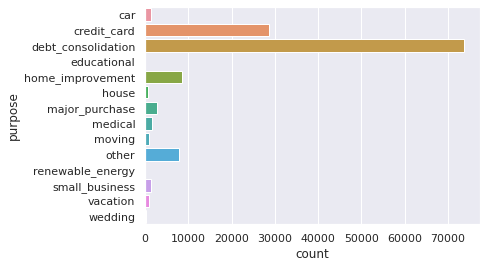

<AxesSubplot:xlabel='count', ylabel='emp_length'>

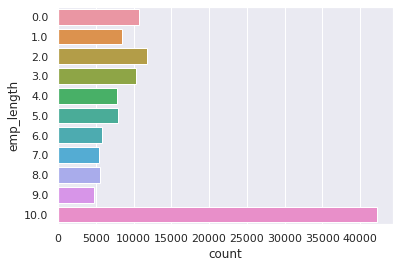

In [121]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [122]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [123]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    26218.000000
mean         0.337173
std          0.914997
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: delinq_2yrs, dtype: float64

count    102604.000000
mean          0.306372
std           0.862462
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: delinq_2yrs, dtype: float64

In [124]:
#df[['fico_range_low', 'fico_range_high']].drop_duplicates().sort_values(['fico_range_low'])

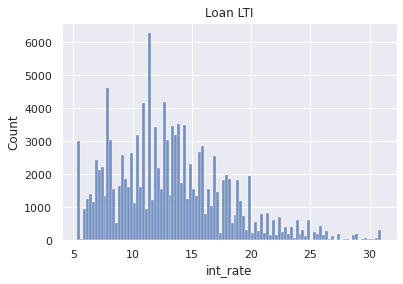

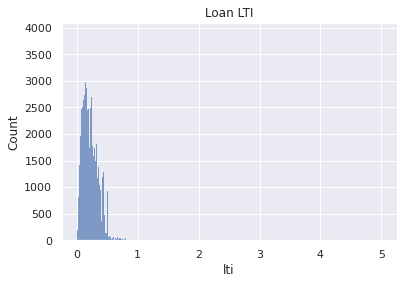

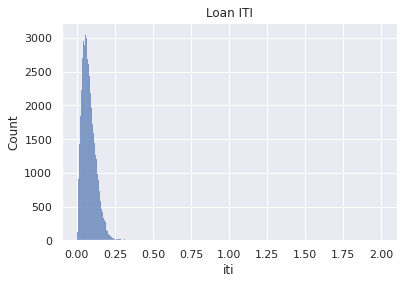

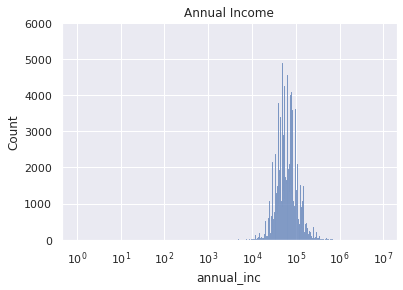

In [125]:
sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

[Text(0.5, 1.0, 'Loan Grade')]

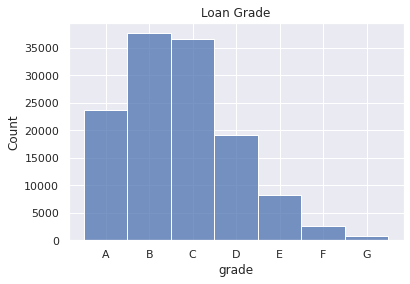

In [126]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

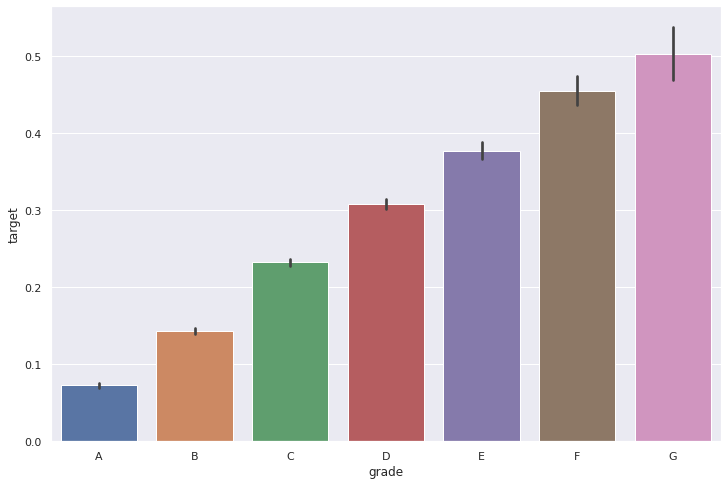

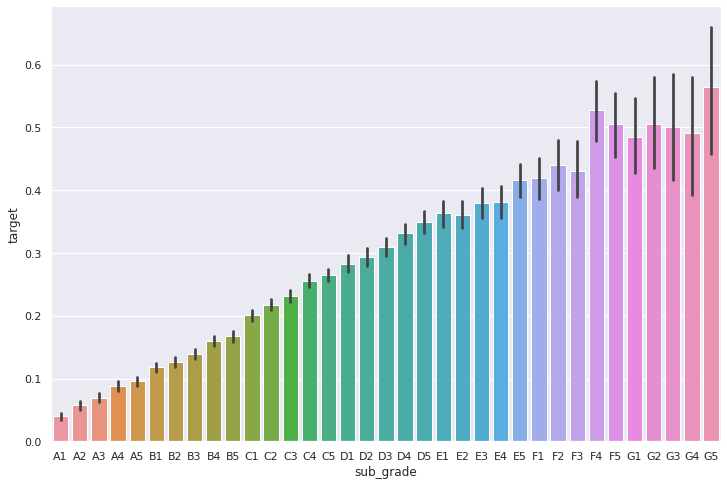

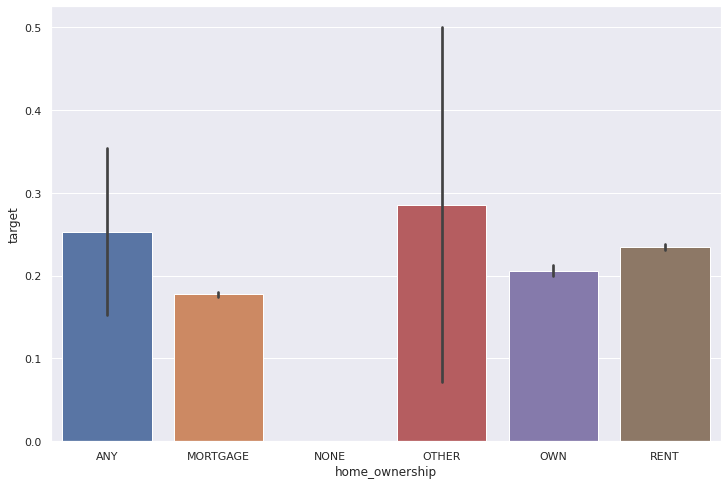

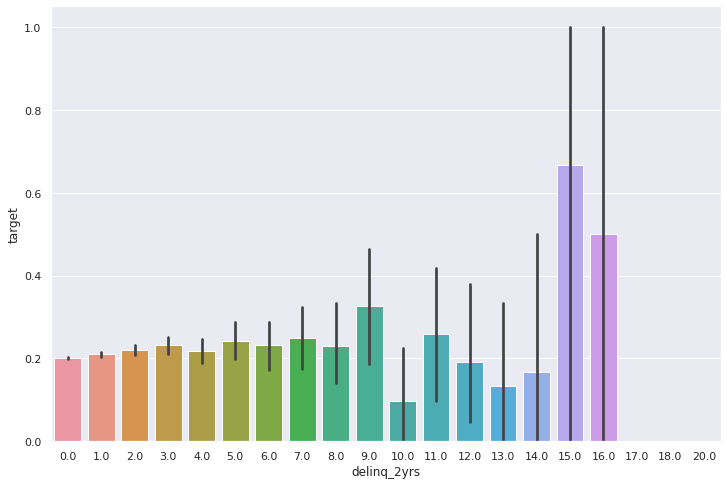

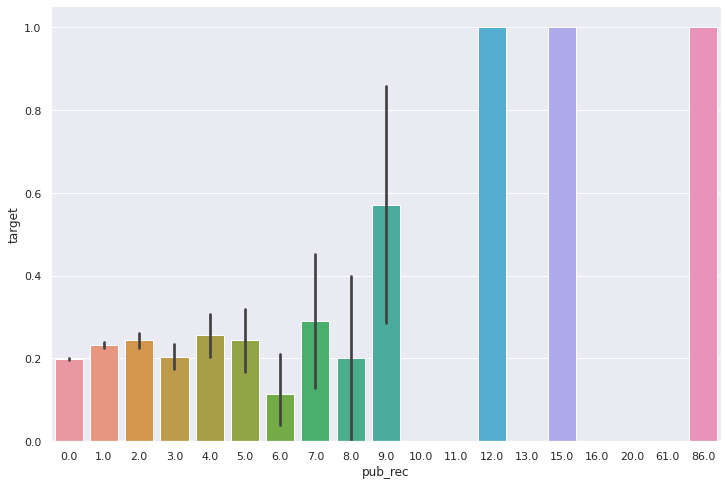

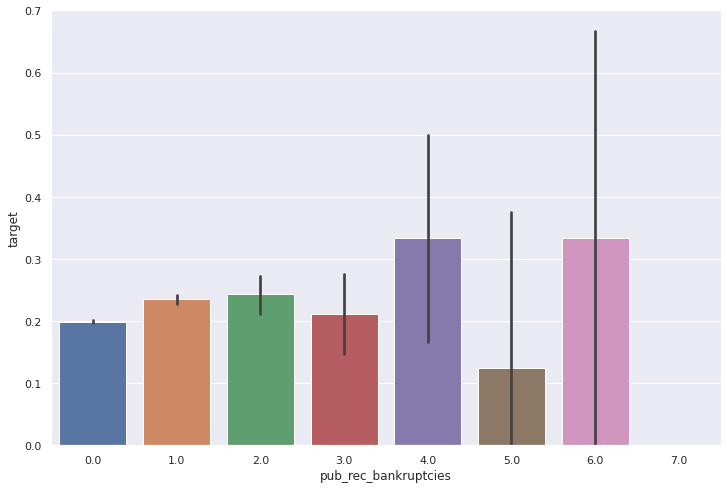

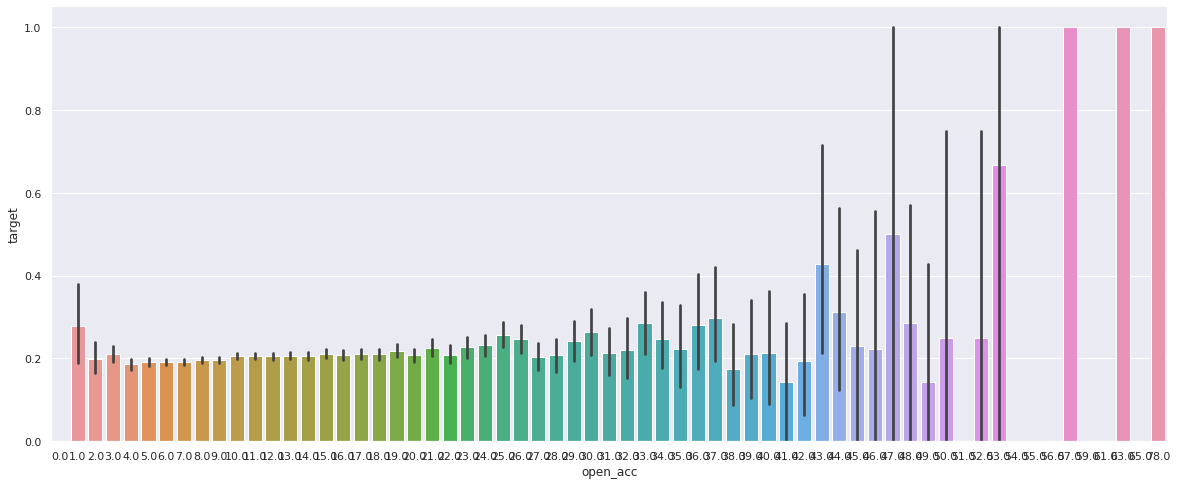

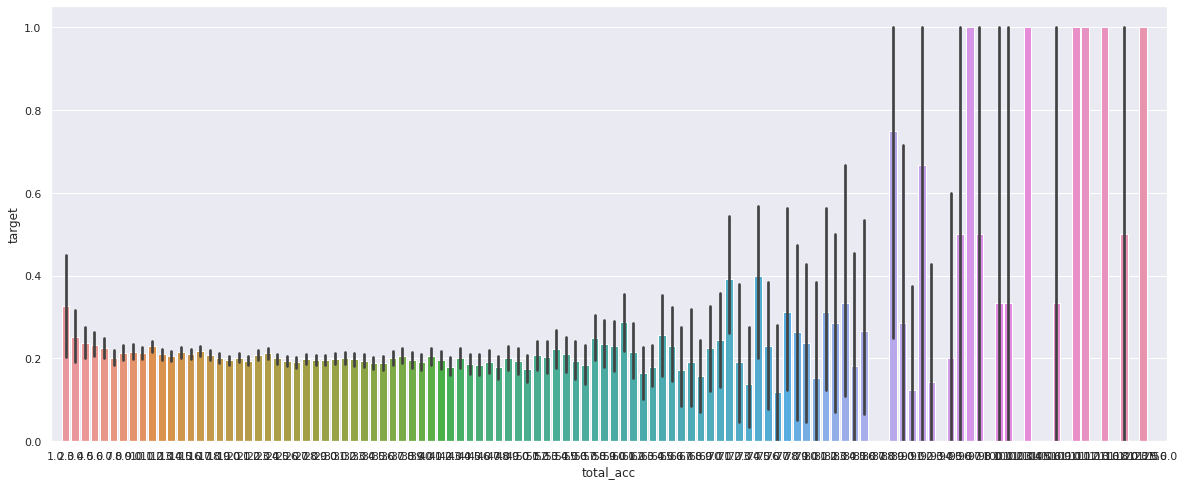

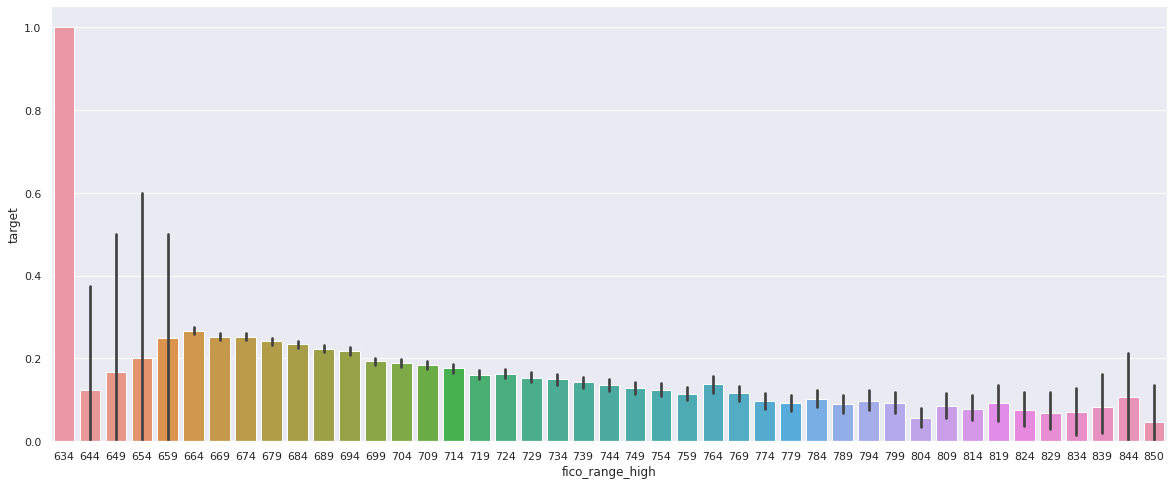

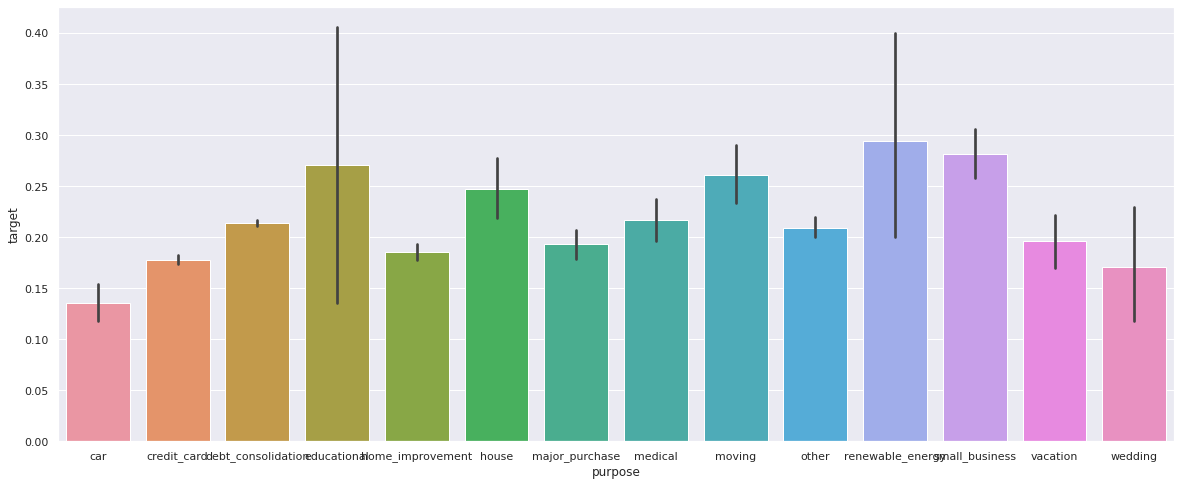

In [127]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()

### Train-test split, missing values

In [128]:
display(df.count())

loan_amnt               128823
funded_amnt             128823
funded_amnt_inv         128823
term                    128823
int_rate                128823
installment             128823
grade                   128823
sub_grade               128823
emp_title               119685
emp_length              120746
home_ownership          128823
annual_inc              128823
verification_status     128823
purpose                 128823
title                   127334
zip_code                128823
addr_state              128823
dti                     128742
delinq_2yrs             128822
fico_range_high         128823
inq_last_6mths          128822
open_acc                128822
pub_rec                 128822
revol_bal               128823
revol_util              128724
total_acc               128822
initial_list_status     128823
application_type        128823
mort_acc                125338
pub_rec_bankruptcies    128727
year_issued             128823
month_issued            128823
year_ear

In [129]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(115941, 44)

(12882, 44)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,low_fico,open_cl_ratio,hobo,was_bankrupt
0,12000,12000,12000.0,36,10.49,389.980011,B,B2,Captain,4.0,MORTGAGE,100000.0,Not Verified,car,Car financing,330,FL,6.200000,0.0,669,0.0,4.0,0.0,3019,24.0,8.0,w,Individual,0.0,0.0,2016,11,2016,10.749023,0.0,1.0,0.120000,0.046798,0,0.030190,0,0.500000,0,0
1,7500,7500,7500.0,36,10.99,245.509995,B,B4,Associate Dentist,0.0,RENT,100000.0,Verified,other,Other,605,IL,22.750000,2.0,669,3.0,28.0,0.0,12088,36.4,44.0,w,Individual,0.0,0.0,2015,10,2015,10.080974,0.0,0.0,0.075000,0.029461,0,0.120880,0,0.636364,0,0
2,22400,22400,22400.0,60,21.99,618.539978,E,E5,a&p mechanic,10.0,MORTGAGE,109000.0,Source Verified,home_improvement,Home improvement,743,OK,23.209999,0.0,729,3.0,18.0,0.0,11356,41.1,52.0,f,Individual,1.0,0.0,2015,2,2015,17.251552,0.0,0.0,0.205505,0.068096,0,0.104183,0,0.346154,0,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,low_fico,open_cl_ratio,hobo,was_bankrupt
11539,7875,7875,7875.0,36,13.99,269.119995,C,C4,Teacher,6.0,MORTGAGE,50000.0,Source Verified,debt_consolidation,Debt consolidation,370,TN,35.48,4.0,664,0.0,8.0,0.0,2761,64.2,44.0,f,Individual,3.0,0.0,2015,7,2015,16.000329,0.000000,0.0,0.157500,0.064589,0,0.055220,0,0.181818,0,0
20330,32000,32000,32000.0,60,23.99,920.390015,F,F2,Trooper,10.0,OWN,109000.0,Verified,debt_consolidation,Debt consolidation,186,PA,34.66,0.0,684,2.0,23.0,0.0,102382,69.0,70.0,f,Individual,2.0,0.0,2015,4,2015,20.750597,0.000000,1.0,0.293578,0.101327,0,0.939284,0,0.328571,0,0
22443,7850,7850,7850.0,36,13.35,265.829987,C,C2,custodian,8.0,RENT,28000.0,Not Verified,credit_card,Credit card refinancing,217,MD,13.29,0.0,674,1.0,6.0,1.0,8468,65.0,16.0,w,Individual,3.0,1.0,2014,10,2014,19.748523,0.050637,1.0,0.280357,0.113927,0,0.302429,0,0.375000,0,1


loan_amnt               115941
funded_amnt             115941
funded_amnt_inv         115941
term                    115941
int_rate                115941
installment             115941
grade                   115941
sub_grade               115941
emp_title               115941
emp_length              115941
home_ownership          115941
annual_inc              115941
verification_status     115941
purpose                 115941
title                   115941
zip_code                115941
addr_state              115941
dti                     115941
delinq_2yrs             115941
fico_range_high         115941
inq_last_6mths          115941
open_acc                115941
pub_rec                 115941
revol_bal               115941
revol_util              115941
total_acc               115941
initial_list_status     115941
application_type        115941
mort_acc                115941
pub_rec_bankruptcies    115941
year_issued             115941
month_issued            115941
year_ear

loan_amnt               12882
funded_amnt             12882
funded_amnt_inv         12882
term                    12882
int_rate                12882
installment             12882
grade                   12882
sub_grade               12882
emp_title               12882
emp_length              12882
home_ownership          12882
annual_inc              12882
verification_status     12882
purpose                 12882
title                   12882
zip_code                12882
addr_state              12882
dti                     12882
delinq_2yrs             12882
fico_range_high         12882
inq_last_6mths          12882
open_acc                12882
pub_rec                 12882
revol_bal               12882
revol_util              12882
total_acc               12882
initial_list_status     12882
application_type        12882
mort_acc                12882
pub_rec_bankruptcies    12882
year_issued             12882
month_issued            12882
year_earliest           12882
years_borr

### Categorical features encoding

In [130]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

35.9526846408844

3.0697927474975586

(115941, 44)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,12000,12000,12000.0,36,10.49,389.980011,4.0,100000.0,Not Verified,6.200000,0.0,669,0.0,4.0,0.0,3019,24.0,8.0,w,Individual,0.0,0.0,2016,11,2016,10.749023,0.0,1.0,0.120000,0.046798,0,0.030190,0,0.500000,0,0,0.141866,0.125371,0.179077,0.176479,0.140920,0.150036,0.235248,0.225495
1,7500,7500,7500.0,36,10.99,245.509995,0.0,100000.0,Verified,22.750000,2.0,669,3.0,28.0,0.0,12088,36.4,44.0,w,Individual,0.0,0.0,2015,10,2015,10.080974,0.0,0.0,0.075000,0.029461,0,0.120880,0,0.636364,0,0,0.141866,0.158715,0.202829,0.234545,0.212755,0.215663,0.140759,0.180955
2,22400,22400,22400.0,60,21.99,618.539978,10.0,109000.0,Source Verified,23.209999,0.0,729,3.0,18.0,0.0,11356,41.1,52.0,f,Individual,1.0,0.0,2015,2,2015,17.251552,0.0,0.0,0.205505,0.068096,0,0.104183,0,0.346154,0,0,0.377138,0.421636,0.202829,0.176479,0.182942,0.188869,0.216981,0.227466
3,15000,15000,15000.0,36,12.69,503.179993,10.0,42000.0,Verified,21.860001,2.0,669,0.0,16.0,0.0,5871,80.4,24.0,f,Individual,0.0,0.0,2015,8,2015,12.085122,0.0,0.0,0.357143,0.143766,0,0.139786,0,0.666667,0,0,0.233779,0.220045,0.202829,0.234545,0.213401,0.218703,0.254089,0.202991
4,25000,25000,25000.0,60,14.08,582.750000,7.0,100000.0,Not Verified,3.130000,0.0,719,1.0,20.0,0.0,10459,10.5,25.0,w,Individual,0.0,0.0,2017,8,2017,10.497135,0.0,1.0,0.250000,0.069930,0,0.104590,0,0.800000,0,0,0.233779,0.229963,0.275299,0.207840,0.213401,0.218703,0.300943,0.226430


loan_amnt                 115941
funded_amnt               115941
funded_amnt_inv           115941
term                      115941
int_rate                  115941
installment               115941
emp_length                115941
annual_inc                115941
verification_status       115941
dti                       115941
delinq_2yrs               115941
fico_range_high           115941
inq_last_6mths            115941
open_acc                  115941
pub_rec                   115941
revol_bal                 115941
revol_util                115941
total_acc                 115941
initial_list_status       115941
application_type          115941
mort_acc                  115941
pub_rec_bankruptcies      115941
year_issued               115941
month_issued              115941
year_earliest             115941
years_borrowing           115940
pub_rec_pa                115940
target                    115941
lti                       115941
iti                       115941
joint     

In [131]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
11539,7875,7875,7875.0,36,13.99,269.119995,6.0,50000.0,Source Verified,35.48,4.0,664,0.0,8.0,0.0,2761,64.2,44.0,f,Individual,3.0,0.0,2015,7,2015,16.000329,0.000000,0.157500,0.064589,0,0.055220,0,0.181818,0,0,0.232001,0.254313,0.189231,0.176902,0.213484,0.218895,0.185471,0.215882
20330,32000,32000,32000.0,60,23.99,920.390015,10.0,109000.0,Verified,34.66,0.0,684,2.0,23.0,0.0,102382,69.0,70.0,f,Individual,2.0,0.0,2015,4,2015,20.750597,0.000000,0.293578,0.101327,0,0.939284,0,0.328571,0,0,0.451796,0.435678,0.201072,0.206457,0.213484,0.218895,0.220640,0.210204
22443,7850,7850,7850.0,36,13.35,265.829987,8.0,28000.0,Not Verified,13.29,0.0,674,1.0,6.0,1.0,8468,65.0,16.0,w,Individual,3.0,1.0,2014,10,2014,19.748523,0.050637,0.280357,0.113927,0,0.302429,0,0.375000,0,1,0.232001,0.218343,0.233392,0.234534,0.176604,0.181726,0.193071,0.219581
103685,10000,10000,10000.0,36,10.91,326.970001,10.0,100000.0,Not Verified,8.80,0.0,689,0.0,10.0,1.0,18672,62.7,20.0,w,Individual,1.0,1.0,2017,10,2017,22.502858,0.044439,0.100000,0.039236,0,0.186720,0,0.500000,0,1,0.143015,0.159171,0.203000,0.176902,0.213484,0.218895,0.202348,0.206670
61363,5000,5000,5000.0,36,9.49,160.149994,2.0,25000.0,Source Verified,8.98,0.0,699,0.0,5.0,0.0,7428,72.1,10.0,w,Individual,0.0,0.0,2016,10,2016,8.082301,0.000000,0.200000,0.076872,0,0.297120,0,0.500000,0,0,0.143015,0.125711,0.203000,0.234534,0.176604,0.181726,0.197047,0.208470


Number of features before transaformation:  (115941, 43)
time to do feature proprocessing:  3.4052624702453613
Number of features after transaformation:  (115941, 47)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__delinq_2yrs,remainder__fico_range_high,remainder__inq_last_6mths,remainder__open_acc,remainder__pub_rec,remainder__revol_bal,remainder__revol_util,remainder__total_acc,remainder__mort_acc,remainder__pub_rec_bankruptcies,remainder__year_issued,remainder__month_issued,remainder__year_earliest,remainder__years_borrowing,remainder__pub_rec_pa,remainder__lti,remainder__iti,remainder__joint,remainder__revol_balance_income,remainder__low_fico,remainder__open_cl_ratio,remainder__hobo,remainder__was_bankrupt,remainder__grade_encoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__home_ownership_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,12000.0,12000.0,12000.0,36.0,10.49,389.980011,4.0,100000.0,6.200000,0.0,669.0,0.0,4.0,0.0,3019.0,24.0,8.0,0.0,0.0,2016.0,11.0,2016.0,10.749023,0.0,0.120000,0.046798,0.0,0.030190,0.0,0.500000,0.0,0.0,0.141866,0.125371,0.179077,0.176479,0.140920,0.150036,0.235248,0.225495
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,7500.0,7500.0,7500.0,36.0,10.99,245.509995,0.0,100000.0,22.750000,2.0,669.0,3.0,28.0,0.0,12088.0,36.4,44.0,0.0,0.0,2015.0,10.0,2015.0,10.080974,0.0,0.075000,0.029461,0.0,0.120880,0.0,0.636364,0.0,0.0,0.141866,0.158715,0.202829,0.234545,0.212755,0.215663,0.140759,0.180955
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,22400.0,22400.0,22400.0,60.0,21.99,618.539978,10.0,109000.0,23.209999,0.0,729.0,3.0,18.0,0.0,11356.0,41.1,52.0,1.0,0.0,2015.0,2.0,2015.0,17.251552,0.0,0.205505,0.068096,0.0,0.104183,0.0,0.346154,0.0,0.0,0.377138,0.421636,0.202829,0.176479,0.182942,0.188869,0.216981,0.227466
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,15000.0,15000.0,15000.0,36.0,12.69,503.179993,10.0,42000.0,21.860001,2.0,669.0,0.0,16.0,0.0,5871.0,80.4,24.0,0.0,0.0,2015.0,8.0,2015.0,12.085122,0.0,0.357143,0.143766,0.0,0.139786,0.0,0.666667,0.0,0.0,0.233779,0.220045,0.202829,0.234545,0.213401,0.218703,0.254089,0.202991
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,25000.0,25000.0,25000.0,60.0,14.08,582.750000,7.0,100000.0,3.130000,0.0,719.0,1.0,20.0,0.0,10459.0,10.5,25.0,0.0,0.0,2017.0,8.0,2017.0,10.497135,0.0,0.250000,0.069930,0.0,0.104590,0.0,0.800000,0.0,0.0,0.233779,0.229963,0.275299,0.207840,0.213401,0.218703,0.300943,0.226430


### Modeling

In [132]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

'Train Accuracy: '

0.8303792446157959

'F1 score: '

0.33780052528789817

'ROCAUC: '

0.6003592000029722

'PRAUC: '

0.6063654458651682

'R20P: '

0.8263462550429749

'Test Accuracy: '

0.7902499611861512

'F1 score: '

0.18021844660194175

'ROCAUC: '

0.539829911830504

'PRAUC: '

0.3741750435170397

'R20P: '

0.4354183590576767

2.3655920028686523

In [133]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.05
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-12 02:29:36,351] A new study created in memory with name: no-name-4bcb4366-a2d8-4c11-8cf9-a6ac153a8d1f
[I 2022-08-12 02:30:22,716] Trial 0 finished with value: 0.5224649650861408 and parameters: {'n_estimators': 947, 'max_depth': 9, 'learning_rate': 0.09813812894419949, 'colsample_bytree': 0.28607509985091295, 'subsample': 0.5030649540332576, 'alpha': 0.6161463158414492, 'lambda': 0.39665229963774756, 'gamma': 1.7634429470154084e-10, 'min_child_weight': 0.15460667737404954}. Best is trial 0 with value: 0.5224649650861408.
[I 2022-08-12 02:30:42,639] Trial 1 finished with value: 0.5323590458838778 and parameters: {'n_estimators': 955, 'max_depth': 7, 'learning_rate': 0.11027967235031291, 'colsample_bytree': 0.44164584846981003, 'subsample': 0.5353015689332397, 'alpha': 0.44249057320328644, 'lambda': 0.8229422186335303, 'gamma': 1.082200882643929e-09, 'min_child_weight': 3.0805052270968414}. Best is trial 1 with value: 0.5323590458838778.
[I 2022-08-12 02:30:47,428] Trial 2 fi

Total time for hypermarameter optimization  168.48353266716003
        n_estimators : 842
           max_depth : 3
       learning_rate : 0.3324705692447011
    colsample_bytree : 0.22425418002238867
           subsample : 0.6930172433468497
               alpha : 0.22108963652618377
              lambda : 1.9415326068374845
               gamma : 2.817080628037288
    min_child_weight : 0.7424058645306237
best objective value : 0.5453161863677143


'Train Accuracy: '

0.8136724713431832

'F1 score: '

0.2546320256702205

'ROCAUC: '

0.5688834893396127

'PRAUC: '

0.48755403488372784

'R20P: '

0.6380874983069214

'Test Accuracy: '

0.7941313460642757

'F1 score: '

0.19685039370078738

'ROCAUC: '

0.5461283282888099

'PRAUC: '

0.3815014510443305

'R20P: '

0.4650959860383944

174.72481989860535

In [134]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi[:30])

,col,FI
9,remainder__funded_amnt_inv,0.007250
8,remainder__funded_amnt,0.003881
32,remainder__iti,0.003819
21,remainder__revol_bal,0.003695
12,remainder__installment,0.003105
40,remainder__sub_grade_encoded,0.002919
42,remainder__home_ownership_encoded,0.002888
7,remainder__loan_amnt,0.002841
10,remainder__term,0.002189
28,remainder__year_earliest,0.002018


,col_name,feature_importance_vals
39,remainder__grade_encoded,0.203165
10,remainder__term,0.177201
17,remainder__fico_range_high,0.141239
31,remainder__lti,0.131590
8,remainder__funded_amnt,0.114646
11,remainder__int_rate,0.113445
28,remainder__year_earliest,0.107607
42,remainder__home_ownership_encoded,0.106341
21,remainder__revol_bal,0.105627
15,remainder__dti,0.102259


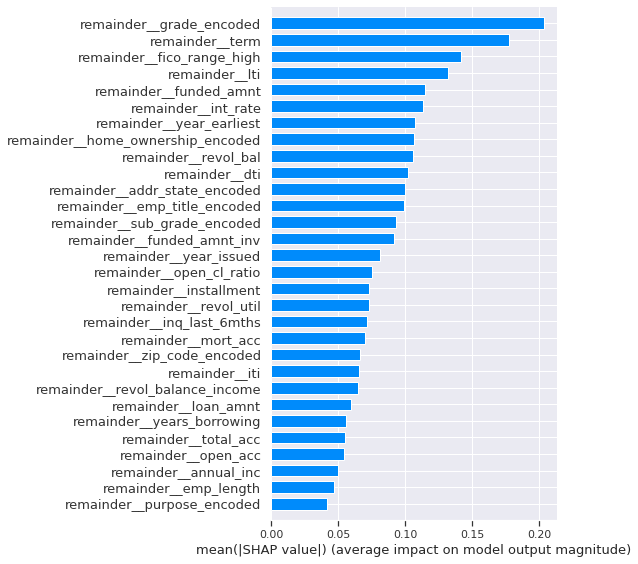

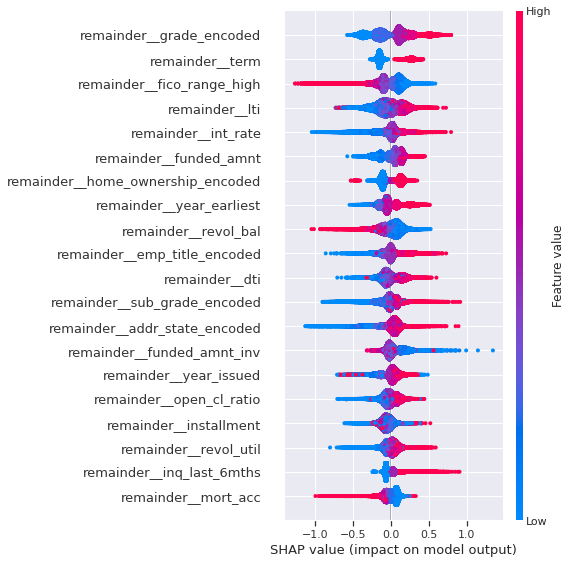

In [135]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance[:30])

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [136]:
time.time()-time0

251.84657502174377